# UA SWE Input Data

This notebook plots the April 1 average (over the 1985-2016 WY study period) of each dataset used in the gridding procedure of UA SWE. Specifically, the datasets are: SNOTEL SWE, SNOTEL Precipitation, SNOTEL Temperature, PRISM Precipitation, and PRISM Temperature.

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from shapely import wkt
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

ModuleNotFoundError: No module named 'contextily'

In [2]:
# Date range for analysis
start_date = datetime(1985,10,1)
end_date = datetime(2016,9,30)

In [3]:
n_yrs = end_date.year - start_date.year

In [4]:
apr1_idx = 90    # apr 1 is 90th day of year

In [5]:
sites_df_dir = '/global/cfs/cdirs/dasrepo/yum/swe/UofA_bias_decomposition/'

sntl_data_dir = '/global/cfs/cdirs/dasrepo/yum/swe/UofA_bias_decomposition/experiments/1985_to_2016/prism/'
prism_data_dir = '/global/cfs/cdirs/dasrepo/yum/swe/UofA_bias_decomposition/data/prism_cleaned/'

save_dir = '/global/cfs/cdirs/dasrepo/yum/swe/uaswe-error-decomposition/figures/'

## Load SNOTEL Sites

In [6]:
# Load list of SNOTEL sites with available data
sites_df = pd.read_csv(sites_df_dir+"sites_df.csv", index_col='Unnamed: 0')

In [7]:
sites_df['geometry'] = sites_df['geometry'].apply(wkt.loads)

In [8]:
# Convert to a Geopandas gdf
sites_gdf = gpd.GeoDataFrame(sites_df, crs='EPSG:4326')

In [9]:
# Get shapefile for Upper Colorado Riber Basin (UCRB)
uc_shp = "/global/cscratch1/sd/yum/swe/Upper_Colorado_River_Basin_Boundary/Upper_Colorado_River_Basin_Boundary.shp"

# Read UCRB shapefile
gm_poly_gdf = gpd.read_file(uc_shp, encoding="utf-8")

# Get bounds of UCRB
gm_poly_geom = gm_poly_gdf.iloc[0].geometry

# Determine sites in UCRB
sites_idx = sites_gdf.intersects(gm_poly_geom)

# Subset df to sites in UCRB
gm_snotel_sites = sites_gdf.loc[sites_idx]

In [10]:
gm_snotel_sites

,code,name,network,elevation_m,site_property,state,geometry
SNOTEL:1030_CO_SNTL,1030_CO_SNTL,Arapaho Ridge,SNOTEL,3340.607910,"{'county': 'Grand', 'state': 'Colorado', 'site...",CO,POINT (-106.38142 40.35098)
SNOTEL:305_CO_SNTL,305_CO_SNTL,Arrow,SNOTEL,2950.464111,"{'county': 'Grand', 'state': 'Colorado', 'site...",CO,POINT (-105.76083 39.91550)
SNOTEL:8082_UT_SNTL,8082_UT_SNTL,Atwood Lake,SNOTEL,3304.031982,"{'county': 'Duchesne', 'state': 'Utah', 'site_...",UT,POINT (-110.28333 40.73333)
SNOTEL:317_WY_SNTL,317_WY_SNTL,Battle Mountain,SNOTEL,2267.711914,"{'county': 'Carbon', 'state': 'Wyoming', 'site...",WY,POINT (-107.26609 41.05413)
SNOTEL:1061_CO_SNTL,1061_CO_SNTL,Bear River,SNOTEL,2767.583984,"{'county': 'Routt', 'state': 'Colorado', 'site...",CO,POINT (-107.00955 40.06153)
...,...,...,...,...,...,...,...
SNOTEL:1160_CO_SNTL,1160_CO_SNTL,Weminuche Creek,SNOTEL,3273.552002,"{'county': 'Archuleta', 'state': 'Colorado', '...",CO,POINT (-107.32152 37.51976)
SNOTEL:859_WY_SNTL,859_WY_SNTL,Whiskey Park,SNOTEL,2727.959961,"{'county': 'Carbon', 'state': 'Wyoming', 'site...",WY,POINT (-106.90848 41.00289)
SNOTEL:864_UT_SNTL,864_UT_SNTL,White River #1,SNOTEL,2633.776855,"{'county': 'Wasatch', 'state': 'Utah', 'site_c...",UT,POINT (-110.98845 39.96450)
SNOTEL:869_CO_SNTL,869_CO_SNTL,Willow Creek Pass,SNOTEL,2907.791992,"{'county': 'Grand', 'state': 'Colorado', 'site...",CO,POINT (-106.09433 40.34703)


## Plot SNOTEL (SWE, P, T)

In [11]:
# add columns
apr1_swe = []
apr1_pr = []
apr1_temp = []

In [12]:
for idx, row in gm_snotel_sites.iterrows():
    # print(idx)
    if os.path.isfile(sntl_data_dir+str(row['code'])+'_concise.csv'):    # if file exists
        df = pd.read_csv(sntl_data_dir+str(row['code'])+'_concise.csv', index_col='Unnamed: 0')
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        if (4 in df['datetime'].dt.month.values) and (1 in df['datetime'].dt.day.values):   # if april 1 exists
            swe = pd.Series(df['snotel_swe'].values, index=df['datetime'])
            pr = pd.Series(df['snotel_pr'].values, index=df['datetime'])
            temp = pd.Series(df['snotel_temp'].values, index=df['datetime'])

            site_n = len(swe.groupby([lambda x: x.year]).count())

            swe_daily_sum = swe.groupby([lambda x: x.month, lambda x: x.day]).sum()
            swe_apr1_mean = swe_daily_sum.iloc[apr1_idx - 1] / (site_n-1)
            pr_daily_sum = pr.groupby([lambda x: x.month, lambda x: x.day]).sum()
            pr_apr1_mean = pr_daily_sum.iloc[apr1_idx - 1] / (site_n-1)
            temp_daily_sum = temp.groupby([lambda x: x.month, lambda x: x.day]).sum()
            temp_apr1_mean = temp_daily_sum.iloc[apr1_idx - 1] / (site_n-1)

            apr1_swe.append(swe_apr1_mean)
            apr1_pr.append(pr_apr1_mean)
            apr1_temp.append(temp_apr1_mean)
            
        else:
            apr1_swe.append(np.nan)
            apr1_pr.append(np.nan)
            apr1_temp.append(np.nan)
            
    else:
        apr1_swe.append(np.nan)
        apr1_pr.append(np.nan)
        apr1_temp.append(np.nan)
    # break

In [13]:
gm_snotel_sites['apr1_swe'] = apr1_swe
gm_snotel_sites['apr1_pr'] = apr1_pr
gm_snotel_sites['apr1_temp'] = apr1_temp

/global/homes/y/yum/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# Average Apr 1 SNOTEL SWE
f, ax = plt.subplots(figsize=(10,6))
gm_poly_gdf.plot(ax=ax, facecolor="none", edgecolor='black', lw=1.5)
gm_snotel_sites.plot(ax=ax, column='apr1_swe', cmap='inferno', legend=True)
ctx.add_basemap(ax=ax, crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
ax.set_title('SNOTEL SWE (mm)')
# plt.savefig(save_dir+'snotel_swe.png', dpi=300)

In [ ]:
# Average Apr 1 SNOTEL Precipitation
f, ax = plt.subplots(figsize=(10,6))
gm_poly_gdf.plot(ax=ax, facecolor="none", edgecolor='black', lw=1.5)
gm_snotel_sites.plot(ax=ax, column='apr1_pr', legend=True, vmin=0, vmax=9.5)
ctx.add_basemap(ax=ax, crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
ax.set_title('SNOTEL Precipitation (mm)')
# plt.savefig(save_dir+'snotel_pr.png', dpi=300)

In [ ]:
# Average Apr 1 SNOTEL Temperatre
f, ax = plt.subplots(figsize=(10,6))
gm_poly_gdf.plot(ax=ax, facecolor="none", edgecolor='black', lw=1.5)
gm_snotel_sites.plot(ax=ax, column='apr1_temp', cmap='plasma', legend=True, vmin=-8.5, vmax=17)
ctx.add_basemap(ax=ax, crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
ax.set_title('SNOTEL Temperature (degC)')
# plt.savefig(save_dir+'snotel_temp.png', dpi=300)

## Plot PRISM (P, T)

In [14]:
# Get UCRB bounds
yy, xx = gm_poly_geom.exterior.coords.xy
xmin, xmax = float(np.min(xx)), float(np.max(xx))
ymin, ymax = float(np.min(yy)), float(np.max(yy))

In [15]:
for filename in sorted(os.listdir(prism_data_dir)):
    # print(filename)
    file_year = int(filename[-7:-3])
    # load precip file
    if '_PR_' in filename:
        if start_date.year <= file_year <= end_date.year:
            # print(filename, str(file_year))
            prism_pr_ds = xr.open_dataset(prism_data_dir+filename)
            if file_year == start_date.year:
                prism_pr_da = prism_pr_ds.PPT
                prism_pr_ucrb_da = prism_pr_da.sel(time=datetime(file_year,4,1), lat=slice(xmin,xmax), lon=slice(ymin,ymax))   # spatial sum
                # prism_pr_ucrb_da = prism_pr_da.sel(lat=slice(xmin,xmax), lon=slice(ymin,ymax))   # spatial sum
                prism_pr_ucrb_sum = prism_pr_ucrb_da.copy()
                # prism_pr_ucrb_sum = prism_pr_ucrb_da.sum(dim=['time'])
                # break
            else:
                prism_pr_da = prism_pr_ds.PPT
                prism_pr_ucrb_da = prism_pr_da.sel(time=datetime(file_year,4,1), lat=slice(xmin,xmax), lon=slice(ymin,ymax))   # spatial sum
                # prism_pr_ucrb_da = prism_pr_da.sel(lat=slice(xmin,xmax), lon=slice(ymin,ymax))   # spatial sum
                prism_pr_ucrb_sum += prism_pr_ucrb_da.copy()
                # prism_pr_ucrb_sum += prism_pr_ucrb_da.sum(dim=['time'])

    # load temp file
    if '_TEMP_' in filename:
        if start_date.year <= file_year <= end_date.year:
            # print(filename, str(file_year))
            prism_temp_ds = xr.open_dataset(prism_data_dir+filename)
            if file_year == start_date.year:
                prism_temp_da = prism_temp_ds.TEMP
                prism_temp_ucrb_da = prism_temp_da.sel(time=datetime(file_year,4,1), lat=slice(xmin,xmax), lon=slice(ymin,ymax))   # spatial sum
                # prism_temp_ucrb_da = prism_temp_da.sel(lat=slice(xmin,xmax), lon=slice(ymin,ymax))   # spatial sum
                prism_temp_ucrb_sum = prism_temp_ucrb_da.copy()
                # prism_temp_ucrb_sum = prism_temp_ucrb_da.sum(dim=['time'])
            else:
                prism_temp_da = prism_temp_ds.TEMP
                prism_temp_ucrb_da = prism_temp_da.sel(time=datetime(file_year,4,1), lat=slice(xmin,xmax), lon=slice(ymin,ymax))   # spatial sum
                # prism_temp_ucrb_da = prism_temp_da.sel(lat=slice(xmin,xmax), lon=slice(ymin,ymax))   # spatial sum
                prism_temp_ucrb_sum += prism_temp_ucrb_da.copy()
                # prism_temp_ucrb_sum += prism_temp_ucrb_da.sum(dim=['time'])

In [16]:
prism_pr_ucrb_mean = prism_pr_ucrb_sum / n_yrs

In [17]:
prism_temp_ucrb_mean = prism_temp_ucrb_sum / n_yrs

In [ ]:
f, ax = plt.subplots(figsize=(10,6))
prism_pr_ucrb_mean.plot(ax=ax, vmin=0, vmax=9.5, cbar_kwargs={'label':''})
gm_poly_gdf.plot(ax=ax, facecolor="none", edgecolor='black', lw=1.5)
ctx.add_basemap(ax=ax, crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
plt.title('PRISM Precipitation (mm)')
# plt.savefig(f'{save_dir}prism_pr.png', dpi=300)

In [ ]:
f, ax = plt.subplots(figsize=(10,6))
prism_temp_ucrb_mean.plot(ax=ax, cmap='plasma', vmin=-8.5, vmax=17, cbar_kwargs={'label':''})
gm_poly_gdf.plot(ax=ax, facecolor="none", edgecolor='black', lw=1.5)
ctx.add_basemap(ax=ax, crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
plt.title('PRISM Temperature (degC)')
# plt.savefig(f'{save_dir}prism_temp.png', dpi=300)

## Plot SNOTEL and PRISM on Common Figure

In [18]:
min_pr, max_pr = min(np.nanmin(gm_snotel_sites['apr1_pr']), np.min(prism_pr_ucrb_mean)), max(np.nanmax(gm_snotel_sites['apr1_pr']), np.max(prism_pr_ucrb_mean))
min_temp, max_temp = min(np.nanmin(gm_snotel_sites['apr1_temp']), np.min(prism_temp_ucrb_mean)).item(), max(np.nanmax(gm_snotel_sites['apr1_temp']), np.max(prism_temp_ucrb_mean)).item()

In [19]:
print(min_pr, max_pr, min_temp, max_temp)

0.0 9.101666666666667 -8.214580535888672 16.727109909057617


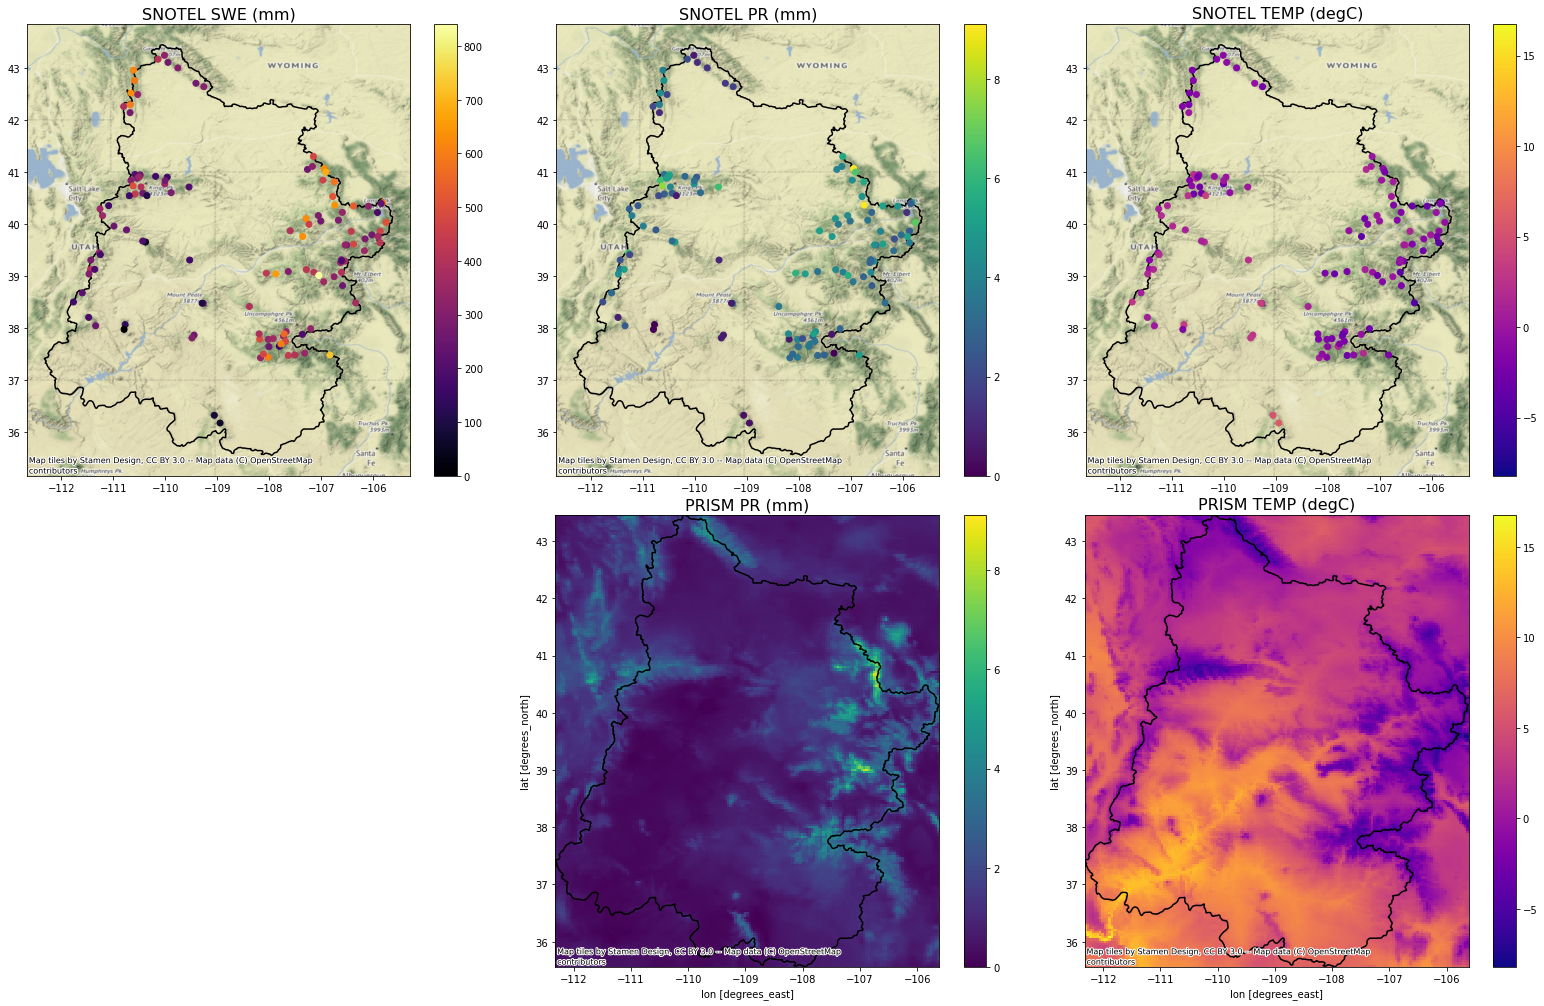

In [21]:
# Average Apr 1 SNOTEL SWE
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(22,14))
gm_poly_gdf.plot(ax=axes[0,0], facecolor="none", edgecolor='black', lw=1.5)
gm_poly_gdf.plot(ax=axes[0,1], facecolor="none", edgecolor='black', lw=1.5)
gm_poly_gdf.plot(ax=axes[0,2], facecolor="none", edgecolor='black', lw=1.5)
gm_snotel_sites.plot(ax=axes[0,0], column='apr1_swe', cmap='inferno', legend=True)
gm_snotel_sites.plot(ax=axes[0,1], column='apr1_pr', vmin=min_pr, vmax=max_pr, legend=True)
gm_snotel_sites.plot(ax=axes[0,2], column='apr1_temp', cmap='plasma', vmin=min_temp, vmax=max_temp, legend=True)
prism_pr_ucrb_mean.plot(ax=axes[1,1], vmin=min_pr, vmax=max_pr, cbar_kwargs={'label':''})
prism_temp_ucrb_mean.plot(ax=axes[1,2], cmap='plasma', vmin=min_temp, vmax=max_temp, cbar_kwargs={'label':''})
gm_poly_gdf.plot(ax=axes[1,1], facecolor="none", edgecolor='black', lw=1.5)
gm_poly_gdf.plot(ax=axes[1,2], facecolor="none", edgecolor='black', lw=1.5)
ctx.add_basemap(ax=axes[0,0], crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax=axes[0,1], crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax=axes[0,2], crs=gm_snotel_sites.crs, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax=axes[1,1], crs=gm_poly_gdf.crs, source=ctx.providers.Stamen.Terrain)
ctx.add_basemap(ax=axes[1,2], crs=gm_poly_gdf.crs, source=ctx.providers.Stamen.Terrain)
axes[1,0].axis('off')
axes[0,0].set_title('SNOTEL SWE (mm)', fontsize=16)
axes[0,1].set_title('SNOTEL PR (mm)', fontsize=16)
axes[0,2].set_title('SNOTEL TEMP (degC)', fontsize=16)
axes[1,1].set_title('PRISM PR (mm)', fontsize=16)
axes[1,2].set_title('PRISM TEMP (degC)', fontsize=16)
# plt.suptitle('UA SWE Data Sources \n (April 1 SWE, PR, TEMP averaged over years for each location)', fontsize=22)
# plt.subplots_adjust(top=0.9)
# plt.subplots_adjust(left = 0.02, top = 0.9, right = 0.98, bottom = 0.05, hspace = 0.1, wspace = 0.1)
plt.tight_layout()
plt.savefig(save_dir+'ua_swe_input_data.png', dpi=300)